<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/Time_Series_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
from torch.utils.data import DataLoader , TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import torch.nn.functional as F
from sklearn.model_selection import train_test_split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
# Load the CSV file; update the filename if needed
df = pd.read_csv("/content/drive/MyDrive/nba/cleaned_data_with_dates.CSV")

df

,team,opponent,attempted_field_goals,attempted_three_point_field_goals,attempted_free_throws,assists,steals,personal_fouls,avg_game_score,percent_fg_made,percent_3p_made,percent_ft_made,ORB,DRB,percent_shots_blocked,TOVR,team_win,opp_win,date
0,12,20,81,30,39,26,8,23,11.033333,0.518519,0.433333,0.717949,0.500000,0.557377,0.016393,0.117112,1,0,140223
1,12,6,82,26,25,22,10,24,8.200000,0.463415,0.423077,0.880000,0.541667,0.466667,0.030303,0.137681,1,0,140327
2,12,24,84,34,33,20,4,20,7.740000,0.404762,0.235294,0.848485,0.250000,0.453333,0.031496,0.056931,0,1,140416
3,12,9,76,24,34,17,6,15,4.950000,0.407895,0.333333,0.647059,0.333333,0.412698,0.008929,0.101594,0,1,140130
4,12,20,92,28,15,26,9,20,6.550000,0.413043,0.285714,0.466667,0.526316,0.436620,0.020408,0.073206,0,1,131121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8940,24,15,80,34,22,23,7,24,7.100000,0.487500,0.382353,0.818182,0.666667,0.561404,0.000000,0.133165,0,1,151220
8941,24,14,87,30,20,29,3,19,7.538462,0.505747,0.500000,0.600000,0.666667,0.532258,0.030928,0.059791,1,0,150115
8942,24,19,89,21,29,15,4,22,7.730000,0.460674,0.285714,0.758621,0.666667,0.480769,0.000000,0.053946,0,1,151212
8943,24,18,78,27,40,17,4,26,8.670000,0.461538,0.333333,0.900000,0.666667,0.557143,0.028846,0.089153,1,0,160318


In [77]:
df = df.sort_values(by="date")



In [78]:
target_column = [
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',

    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]

# Inputs
X= df[target_column]
# Outputs
y = df['team_win']
scaler = StandardScaler()
training_data = scaler.fit_transform(X)

training_data.shape[0]

y


,team_win
7442,1
1915,1
3056,0
19,1
5601,1
...,...
4306,1
4330,1
8423,0
6008,1


In [79]:
X_tensor = torch.tensor(training_data, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Reshape X for 1D CNN: (batch_size, channels=1, sequence_length=14)
X_tensor = X_tensor.unsqueeze(1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 3, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # raw logits
        return x


model = CNN1D()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
# Training loop
for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:


        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()


        if torch.isnan(outputs).any():

            continue

        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    logits = model(X_test).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    accuracy = (preds == y_test).float().mean()
    print(f"✅ Test Accuracy: {accuracy:.4f}")



Epoch 1, Loss: 239.5657
Epoch 2, Loss: 211.9772
Epoch 3, Loss: 196.0227
Epoch 4, Loss: 188.1271
Epoch 5, Loss: 181.3063
Epoch 6, Loss: 178.8973
Epoch 7, Loss: 175.0303
Epoch 8, Loss: 174.2920
Epoch 9, Loss: 170.2745
Epoch 10, Loss: 169.6323
Epoch 11, Loss: 166.7718
Epoch 12, Loss: 164.7178
Epoch 13, Loss: 162.7003
Epoch 14, Loss: 160.3758
Epoch 15, Loss: 158.7719
Epoch 16, Loss: 160.2392
Epoch 17, Loss: 157.6658
Epoch 18, Loss: 159.3346
Epoch 19, Loss: 156.3837
Epoch 20, Loss: 154.3897
✅ Test Accuracy: 0.8262


In [ ]:
y_true = y_test.cpu().numpy()
y_pred = preds.cpu().numpy()

# Evaluation metrics
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\n📝 Classification Report:\n", classification_report(y_true, y_pred, digits=3))

✅ Accuracy: 0.8261598658468418

📊 Confusion Matrix:
 [[789 135]
 [176 689]]

📝 Classification Report:
               precision    recall  f1-score   support

         0.0      0.818     0.854     0.835       924
         1.0      0.836     0.797     0.816       865

    accuracy                          0.826      1789
   macro avg      0.827     0.825     0.826      1789
weighted avg      0.827     0.826     0.826      1789



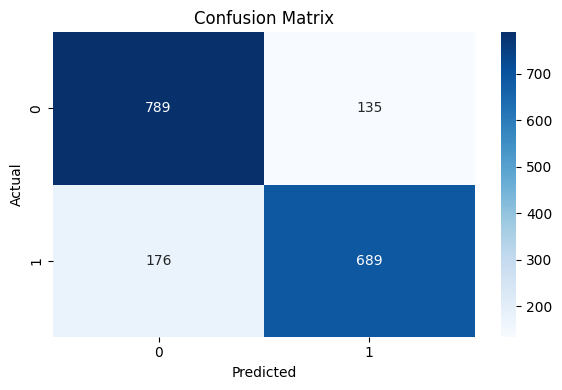

In [ ]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [84]:
n_filters1 = [8,16]
n_filters2 = [16,32]
fc_size = [32,64]
lr = [1e-3,5e-4]

class CNN1D(nn.Module):
    def __init__(self, n_filters1, n_filters2, fc_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, n_filters1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_filters1, n_filters2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_filters2 * 3, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # raw logits
        return x


max_accuracy = 0.0
best_params = {"n_filters1" : 0.0, "n_filters2" :0.0, "fc_size" : 0.0, "lr" : 0.0}


for i in range(len(n_filters1)):
    for j in range(len(n_filters2)):
          for l in range(len(fc_size)):
              for m in range(len(lr)):
                  model = CNN1D(n_filters1[i], n_filters2[j], fc_size[l])
                  criterion = nn.BCEWithLogitsLoss()
                  optimizer = torch.optim.Adam(model.parameters(), lr=lr[m])

                  for epoch in range(1, 21):
                    model.train()
                    total_loss = 0.0
                    for batch_X, batch_y in train_loader:


                        optimizer.zero_grad()
                        outputs = model(batch_X).squeeze()


                        if torch.isnan(outputs).any():

                            continue

                        loss = criterion(outputs, batch_y)
                        loss.backward()

                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                        optimizer.step()
                        total_loss += loss.item()

                    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

                  model.eval()

                  with torch.no_grad():
                      logits = model(X_test).squeeze()
                      probs = torch.sigmoid(logits)
                      preds = (probs > 0.5).float()
                      accuracy = (preds == y_test).float().mean()
                      print(f"✅ Test Accuracy: {accuracy:.4f}")
                  if accuracy > max_accuracy:
                      max_accuracy = accuracy
                      best_params["n_filters1"] = n_filters1[i]
                      best_params["n_filters2"] = n_filters2[j]
                      best_params["fc_size"] = fc_size[l]
                      best_params["lr"] = lr[m]






Epoch 1, Loss: 123.1372
Epoch 2, Loss: 110.0344
Epoch 3, Loss: 106.4722
Epoch 4, Loss: 102.1245
Epoch 5, Loss: 98.6579
Epoch 6, Loss: 96.3776
Epoch 7, Loss: 94.5270
Epoch 8, Loss: 93.1400
Epoch 9, Loss: 91.0959
Epoch 10, Loss: 90.3861
Epoch 11, Loss: 89.3952
Epoch 12, Loss: 88.6312
Epoch 13, Loss: 88.3501
Epoch 14, Loss: 86.9637
Epoch 15, Loss: 86.2475
Epoch 16, Loss: 86.0176
Epoch 17, Loss: 85.6224
Epoch 18, Loss: 84.3820
Epoch 19, Loss: 83.5627
Epoch 20, Loss: 84.0374
✅ Test Accuracy: 0.8228
Epoch 1, Loss: 134.7803
Epoch 2, Loss: 113.7653
Epoch 3, Loss: 110.8774
Epoch 4, Loss: 107.8731
Epoch 5, Loss: 105.4149
Epoch 6, Loss: 103.8643
Epoch 7, Loss: 101.7128
Epoch 8, Loss: 99.9426
Epoch 9, Loss: 98.1193
Epoch 10, Loss: 95.9822
Epoch 11, Loss: 94.5632
Epoch 12, Loss: 93.6891
Epoch 13, Loss: 92.4882
Epoch 14, Loss: 92.2337
Epoch 15, Loss: 90.9951
Epoch 16, Loss: 89.9172
Epoch 17, Loss: 89.7610
Epoch 18, Loss: 88.8281
Epoch 19, Loss: 88.7205
Epoch 20, Loss: 88.2225
✅ Test Accuracy: 0.8032

In [85]:
print("max accuracy" , max_accuracy)
print("best params" , best_params)

max accuracy tensor(0.8267)
best params {'n_filters1': 8, 'n_filters2': 32, 'fc_size': 32, 'lr': 0.001}


# LSTM

In [ ]:
X = df[target_column]
y = df['team_win']

# Normalize input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(2)  # shape: (batch, 14, 1)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Ensure binary target
y_tensor = (y_tensor > 0.5).float()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)               # lstm_out: (batch, seq_len, hidden_dim)
        last_output = lstm_out[:, -1, :]         # get last time step output
        output = self.fc(last_output)            # shape: (batch, 1)
        return output                            # raw logits

# ----------- Training -----------

model = LSTMClassifier()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 50):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()

        if torch.isnan(outputs).any():
            #print("⚠️ NaNs detected in output!")
            continue

        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ----------- Evaluation -----------

model.eval()
with torch.no_grad():
    logits = model(X_test).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    accuracy = (preds == y_test).float().mean()
    print(f"📊 LSTM Test Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 123.5867
Epoch 2, Loss: 111.2213
Epoch 3, Loss: 97.9465
Epoch 4, Loss: 94.5952
Epoch 5, Loss: 93.3551
Epoch 6, Loss: 92.4203
Epoch 7, Loss: 91.4145
Epoch 8, Loss: 89.7251
Epoch 9, Loss: 88.8953
Epoch 10, Loss: 88.3125
Epoch 11, Loss: 88.2870
Epoch 12, Loss: 86.7667
Epoch 13, Loss: 86.0222
Epoch 14, Loss: 85.4742
Epoch 15, Loss: 84.0956
Epoch 16, Loss: 83.8745
Epoch 17, Loss: 83.3542
Epoch 18, Loss: 82.3154
Epoch 19, Loss: 81.4166
Epoch 20, Loss: 80.7380
Epoch 21, Loss: 78.6329
Epoch 22, Loss: 78.8809
Epoch 23, Loss: 77.7690
Epoch 24, Loss: 77.3297
Epoch 25, Loss: 76.7742
Epoch 26, Loss: 76.0088
Epoch 27, Loss: 75.6613
Epoch 28, Loss: 74.9386
Epoch 29, Loss: 74.9629
Epoch 30, Loss: 74.4753
Epoch 31, Loss: 73.9668
Epoch 32, Loss: 73.2291
Epoch 33, Loss: 72.8602
Epoch 34, Loss: 71.9842
Epoch 35, Loss: 71.4710
Epoch 36, Loss: 70.8271
Epoch 37, Loss: 70.3530
Epoch 38, Loss: 69.6431
Epoch 39, Loss: 68.3121
Epoch 40, Loss: 67.2516
Epoch 41, Loss: 66.9373
Epoch 42, Loss: 66.2163